# Check all comment code duay and every detail

# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 2602454 Business Intelligence System</p>

# <p style="padding:20px; border:5px Outset #EBEBEB; background: linear-gradient(to right, #0099FF, #00FF7F); font-family:'Times_New_Roman'; text-align:left;padding: 20px; border: 2px solid #EBEBEB; font-size: 25px; color: #000; font-weight: bold">2602454 Business Intelligence System</p>


# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> Outline</p>

* [ 1. Import dataset and libraries ](#1)
    * [1.1 Data Cleaning](#1.1)
    * [1.2 Data summary](#1.2)
* [ 2. EDA](#2)
* [ 3. Models](#3)
    * [3.1 Split Train Test](#3.1)
    * [3.2 FLAML](#3.2)


<a id="1"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 1. Import dataset and libraries</p>

In [42]:
import re
import os
import csv
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from ipywidgets import interact
import seaborn as sns
plt.rcParams['font.family'] = 'Tahoma'

In [43]:
def get_data(path):
    dir_path = path
    for filename in os.listdir(dir_path):
        if filename.endswith('.csv'):
            with open(os.path.join(dir_path, filename)) as csvfile:
                data = list(csv.reader(csvfile))
            yield data

def create_dataframe(data):
    for d in data:
        try:
            df = pd.DataFrame(d[1:], columns=d[0])
            yield df
        except Exception as e:
            print(f"Error creating DataFrame: {e}")

data = get_data('data/')
df_list = list(create_dataframe(data))
df = reduce(lambda df1,df2: pd.merge(df1,df2,how ='outer'), df_list)
df = df.iloc[:, 5:]

# Import data and convert it into 1 dataframe

In [44]:
def clean_space(df, columns: dict):
    df_copy = df.copy()
    for column in columns:
            df_copy[column] = df_copy[column].astype(str)
            df_copy[column] = df_copy[column].str.replace('\n', '').str.strip()
            df_copy[column] = df_copy[column].apply(lambda x: re.sub(r'\s{2,}', columns[column], x))
            yield column, df_copy[column]

def replace_column_data(df, columns_data: dict):
    df_replaced = df.copy()
    for key in columns_data.keys():
        df_replaced[key] = columns_data[key]
    return df_replaced

clean_columns = dict(clean_space(df, {"facility": ',', "space": ' '}))
df = replace_column_data(df, clean_columns)

<a id="1.1"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; color: #4B0082; text-align:left; padding:10px; border-bottom: 3px solid #4B0082"> 1.1 Data Cleaning</p>

# Clean data

## clean empty data to NaN and change type of data to its correct type

In [45]:
df = df.replace(["null", "ไม่มีข้อมูล"], np.NaN)

df["price"] = df["price"].replace(r",", '', regex = True).astype(float)

df["space"] = df["space"].str.extract(r"([\d\.]+[\d+])").astype(float)

df["year"] = df["year"].str.extract(r"(\d{4})").astype(float)

df["bedroom"] = df["bedroom"].replace("สตูดิโอ", 0).astype(float)

df["bathroom"] = df["bathroom"].astype(float)

df["floor"] = df["floor"].astype(float)

In [46]:
df.rename(columns={"area (keat)": "area", "Province": "province"}, inplace=True)

## extract number distance from station and convert to float

In [47]:
def station(df):
    for i in range(len(df)):
        if isinstance(df['station'][i], float) and np.isnan(df['station'][i]):
            yield np.NaN, np.NaN, np.NaN
        else:
            match = re.search(r'สถานีใกล้เคียง\d+ นาที \((\d+) ม.\) ถึง (\w+)\s(\w+)\s[ก-๙]+', str(df['station'][i]))
            yield match.groups() if match else np.nan

test_df = pd.DataFrame(station(df))
test_df.columns = ['distance','station_id','station_type']
test_df["distance"] = test_df["distance"].astype(float)
df = pd.merge(df, test_df, left_index=True, right_index=True, how="left")
df = df.drop(columns="station")

## seperate each function of facility into their own category

In [48]:
def separate_facilities(df, **kwargs):
    for col_name, keywords in kwargs.items():
        df[col_name] = df["facility"].apply(lambda x: True if isinstance(x, str) and any(keyword in x for keyword in keywords) else False)
    return df

df = separate_facilities(df, 
                            is_Security = ['รักษาความปลอดภัย 24 ชม.','ระบบรักษาความาปลอดภัยการเข้า-ออกอาคาร'],
                            is_Laundry =['ซัก อบ รีด', 'เครื่องซักผ้า'],
                            is_Parking_Lot= ['ที่จอดรถ','ลานจอดรถ','ลานจอดรถใต้ดิน','โรงรถ'],
                            is_Bus_Stop= ['ป้ายรถเมล์'],
                            is_Cleaning=['พนักงานทำความสะอาด'],
                            is_Fitness =['ฟิตเนส','ลู่วิ่ง',],
                            is_Convenient_Store = ['มินิมาร์ท',],
                            is_Balcony=['ระเบียง',],
                            is_View = ['วิวทะเล','วิวสระว่ายน้ำ','วิวเมือง','สวน/วิวสวนธรรมชาติ'],
                            is_Sport_Facility = ['สนามบาส','สนามสควอช','สนามหัดเล่นกอล์ฟ','สนามเด็กเล่น','สนามเทนนิส','สนามแบดมินตัน','ห้องบิลเลียด','ห้องยิมนาสติก'],
                            is_Pool =['สปา สระว่ายน้ำ','สระว่ายน้ำ','สระว่ายน้ำส่วนตัว','สระว่ายน้ำเพื่อความสนุก','สระเด็ก',],
                            is_Park= ['สวนสาธารณะ',],
                            is_Garden = ['สวนส่วนตัว',],
                            is_corner_room = ['ห้องมุม',])

df = df.drop(columns="facility")

# Recheck ด้วย อันนี้ แค่คร่าวๆ

| Column Name   | Explanation                                     |
| ------------- | -------------------------------------------------|
| name          | Name of the property or listing                 |
| price         | Price of the property or listing                |
| province      | Province where the property is located          |
| area  | Area of the property in "keat" units            |
| district      | District where the property is located          |
| bedroom       | Number of bedrooms in the property             |
| bathroom      | Number of bathrooms in the property            |
| space         | Space or size of the property                  |
| year          | Year of construction or listing                |
| type          | Type of property (e.g., house, apartment, etc.)|
| furniture     | Information about the furniture in the property|
| floor         | Floor number or level of the property          |
| distance (m.) | Distance to a certain point (e.g., a station) in meters|
| station_type  | Type of nearby station (e.g., MRT, BTS, etc.)    |
| station_name  | Name of the nearby station                      |

# Delete Column 
ลบ column ที่ซ้ำซ้อน

In [49]:
df = df.drop(['province', 'station_type', 'area'], axis = 1)

In [50]:
df.head(3)

,name,price,district,bedroom,bathroom,space,year,type,furniture,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
2,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False


## Clean name column

In [51]:
df["name"] = df["name"].str.extract(r"(?P<name>.+)[,]")
df["name"] = df["name"].str.extract(r"(?P<name>.+?[:]|.+)")
df["name"] = df["name"].str.replace(":", "").str.strip()

# Clean district column



In [52]:
district_name = {'The Met Sathorn' : 'ทุ่งมหาเมฆ',
 'ASHTON Silom : แอชตัน สีลม' : 'สุริยวงศ์',
 'Nara 9 สาทร-นราธิวาส': 'ทุ่งมหาเมฆ',
 'StarView Rama 3' : 'บางโคล่',
 'Villa Sathorn':'คลองต้นไทร',
 'The Park Chidlom' : 'ลุมพินี',
 r'M สีลม \(เอ็ม สีลม\)' : 'สุริยวงศ์',
 'Supalai Premier Ratchada-Narathiwas-Sathorn : ศุภาลัย พรีเมียร์ รัชดาฯ-นราธิวาส-สาทร' : 'ช่องนนทรี',
 r'Baan Nonsi \(บ้านนนทรี\)' : 'ช่องนนทรี',
 r'CU Terrace \(ระเบียงจามจุรี\)' : 'วังใหม่',
 'ปทุมวัน โอเอซิส คอนโดมิเนียม' : 'วังใหม่',
 'สุพรีม คลาสิค คอนโดมิเนียม' : 'ทุ่งมหาเมฆ'
 }
for key in district_name:
    df.loc[df['district'].str.contains(key), 'district'] = district_name[key]

df['district'].value_counts()

ลุมพินี            1584
ทุ่งมหาเมฆ          788
คลองต้นไทร          744
สีลม                708
ช่องนนทรี           584
บางโพงพาง           391
ยานนาวา             309
ดาวคะนอง            275
บางลำภูล่าง         256
ทุ่งวัดดอน          249
สี่พระยา            248
มหาพฤฒาราม          207
บุคคโล              185
บางโคล่             182
วัดพระยาไกร         155
ตลาดพลู             143
สุริยวงศ์           115
วังใหม่              94
บางคอแหลม            78
คลองสาน              62
สำเหร่               49
รองเมือง             38
สมเด็จเจ้าพระยา      10
ปทุมวัน               9
บางยี่เรือ            7
หิรัญรูจี             6
บางรัก                1
Name: district, dtype: int64

<a id="2"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 2. EDA</p>

In [53]:
df.head(3)

,name,price,district,bedroom,bathroom,space,year,type,furniture,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
0,Supalai Casa Riva,17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
1,Supalai Casa Riva,19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
2,Lumpini Place Rama 3 - Riverview,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False


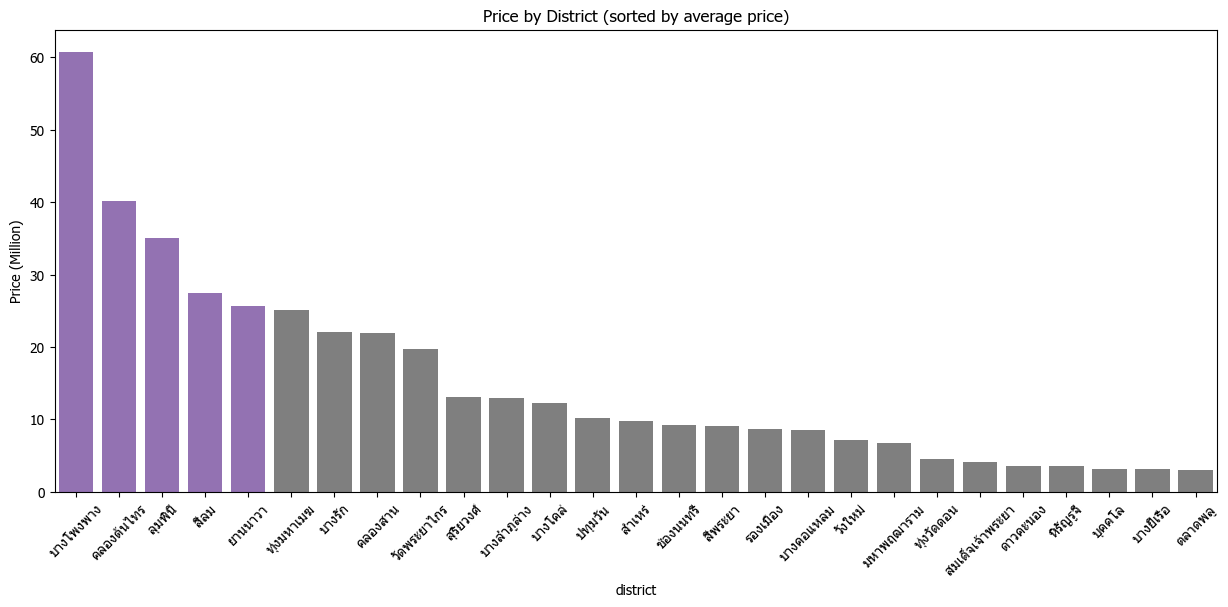

In [54]:
avg_price_by_district = df.groupby('district')['price'].mean().sort_values(ascending=False)

# create barplot with sorted order
plt.figure(figsize=(15,6))
color = ['tab:purple' if i < 5 else 'tab:grey' for i in range(len(df))]
sns.barplot(x=df['district'], y=df['price']/1e6, order=avg_price_by_district.index, errorbar=None, palette = color)
plt.title('Price by District (sorted by average price)')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.ylabel("Price (Million)")
plt.show()

In [55]:
#pointplot --> price , district, year (interact)
district_names = df["district"].unique()
district_names# 

array(['บางคอแหลม', 'บางโคล่', 'วัดพระยาไกร', 'สีลม', 'สี่พระยา',
       'มหาพฤฒาราม', 'สุริยวงศ์', 'บางรัก', 'คลองต้นไทร', 'บางลำภูล่าง',
       'คลองสาน', 'สมเด็จเจ้าพระยา', 'ทุ่งมหาเมฆ', 'ยานนาวา',
       'ทุ่งวัดดอน', 'ช่องนนทรี', 'ลุมพินี', 'ปทุมวัน', 'รองเมือง',
       'วังใหม่', 'บุคคโล', 'ดาวคะนอง', 'สำเหร่', 'ตลาดพลู', 'หิรัญรูจี',
       'บางยี่เรือ', 'บางโพงพาง'], dtype=object)

In [56]:
@interact(District=district_names)
def price_year(District='ลุมพินี'):
    plt.figure(figsize=(10,5))
    graph = df[df['district'].isin([District])]

    year_data = graph[["year", "price"]].dropna() # drop NaN values and assign the returned DataFrame to year_data

    year_data['year'] = year_data['year'].apply(lambda x: '{:.0f}'.format(x))

    sns.pointplot(x=year_data["year"].astype(int), y=year_data['price'], color='indigo', errorbar=None)
    plt.title(f'Price distribution for {District}')
    plt.xticks(rotation=45)

    ax = plt.gca()

    def y_axis_numformat(y, pos):
        return "{:,.0f}".format(y)
    plt.ylim(0, None)

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_axis_numformat))
    plt.show();

interactive(children=(Dropdown(description='District', index=16, options=('บางคอแหลม', 'บางโคล่', 'วัดพระยาไกร…

In [57]:
rows = [312, 313, 1022, 1374, 2461, 3462, 3463, 3465, 3466, 3797, 6529, 6447, 925, 1931, 2461, 2744, 2745, 3210, 3221, 3331, 4557, 5428, 2822, 2897, 4092, 4269, 4354, 4413, 4591, 5175, 5191, 5527, 5594, 5628]
df = df.drop(index=rows)

In [58]:
plot_column = df[['price','bedroom','bathroom', 'space', 'year', 'floor', 'distance']]
plot_column

,price,bedroom,bathroom,space,year,floor,distance
0,17500000.0,3.0,3.0,240.00,2006.0,NaN,720.0
1,19000000.0,3.0,3.0,230.00,2006.0,NaN,720.0
2,2500000.0,1.0,1.0,39.00,2004.0,NaN,150.0
3,3100000.0,1.0,1.0,40.00,2004.0,NaN,150.0
4,28500000.0,1.0,1.0,39.00,2004.0,NaN,150.0
...,...,...,...,...,...,...,...
7472,7490000.0,3.0,3.0,142.00,2014.0,6.0,450.0
7473,2350000.0,1.0,1.0,28.74,2011.0,34.0,460.0
7474,5500000.0,2.0,2.0,94.00,2007.0,7.0,560.0
7475,12500000.0,2.0,2.0,165.67,NaN,45.0,950.0


## Box plot to check value outliner

In [59]:
columns_name = ["price", 'bedroom', 'bathroom', 'space', 'year', 'floor', 'distance']
@interact(column=columns_name)
def price_year(column):
    df.boxplot(column=column)

    plt.ylabel(column)
    plt.title('Box Plot from DataFrame')

    plt.show()

interactive(children=(Dropdown(description='column', options=('price', 'bedroom', 'bathroom', 'space', 'year',…

## clean wrong outliner

### recheck duay

In [60]:
df.loc[4564, "floor"] = 15 #ตึกไม่สูงพอ
df.loc[2662, "space"] = 605 #ตึกไม่กว้างพอ (เทียบกับห้องอื่นโครงเดียวกัน)
df.loc[7076, "price"] = 19_800_000 #แพงไปไม่มีใครซื้อ

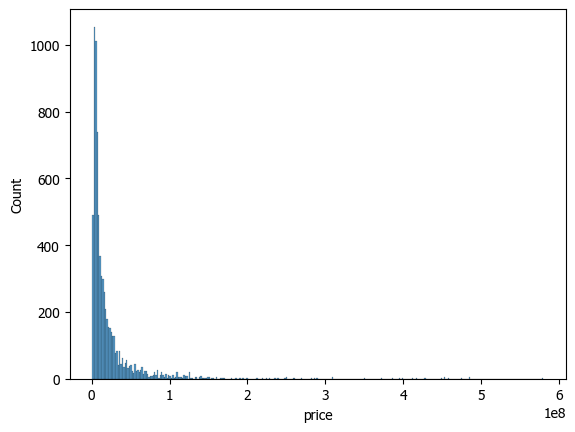

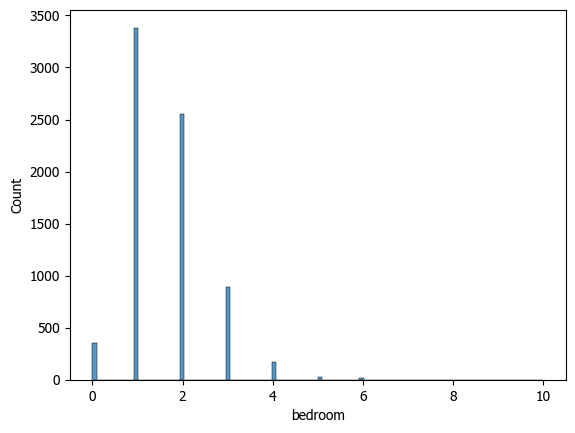

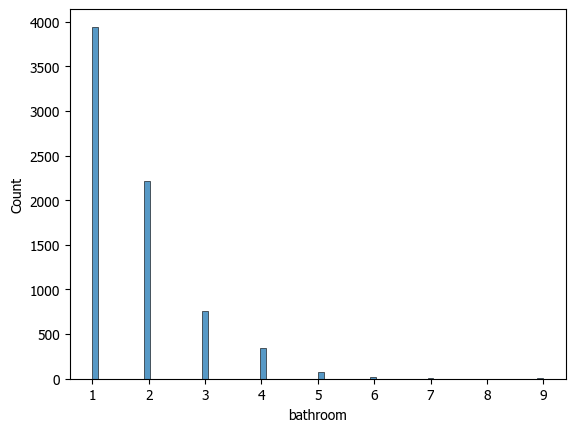

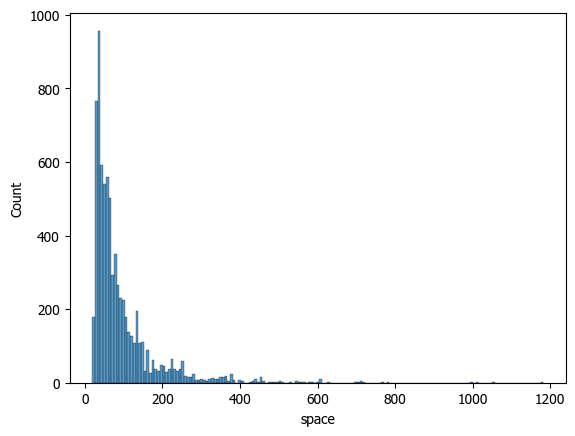

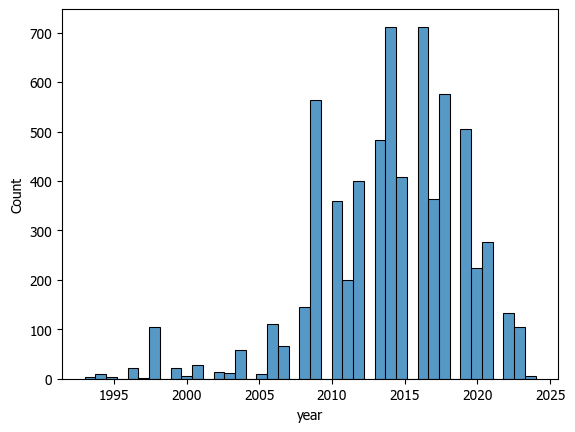

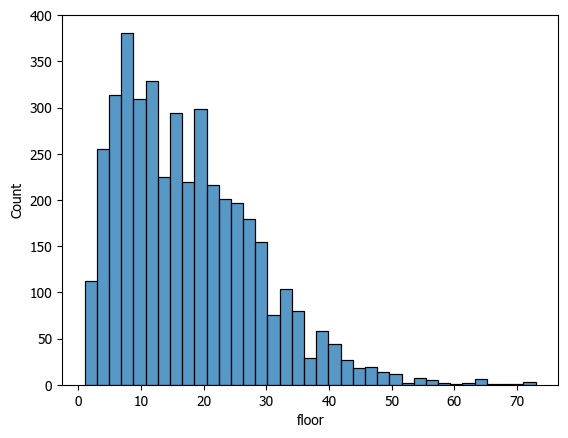

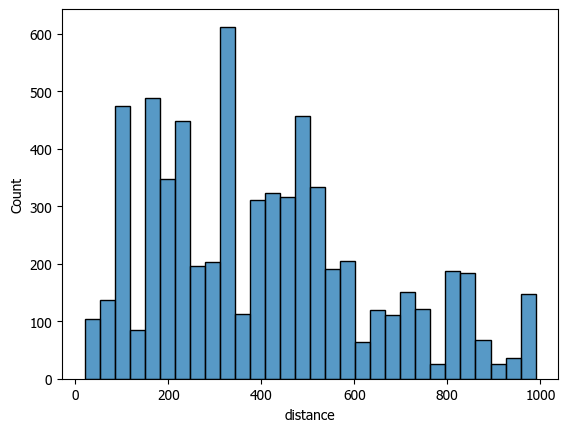

In [61]:
for plots in plot_column.columns:
    sns.histplot(df[plots])
    plt.show()

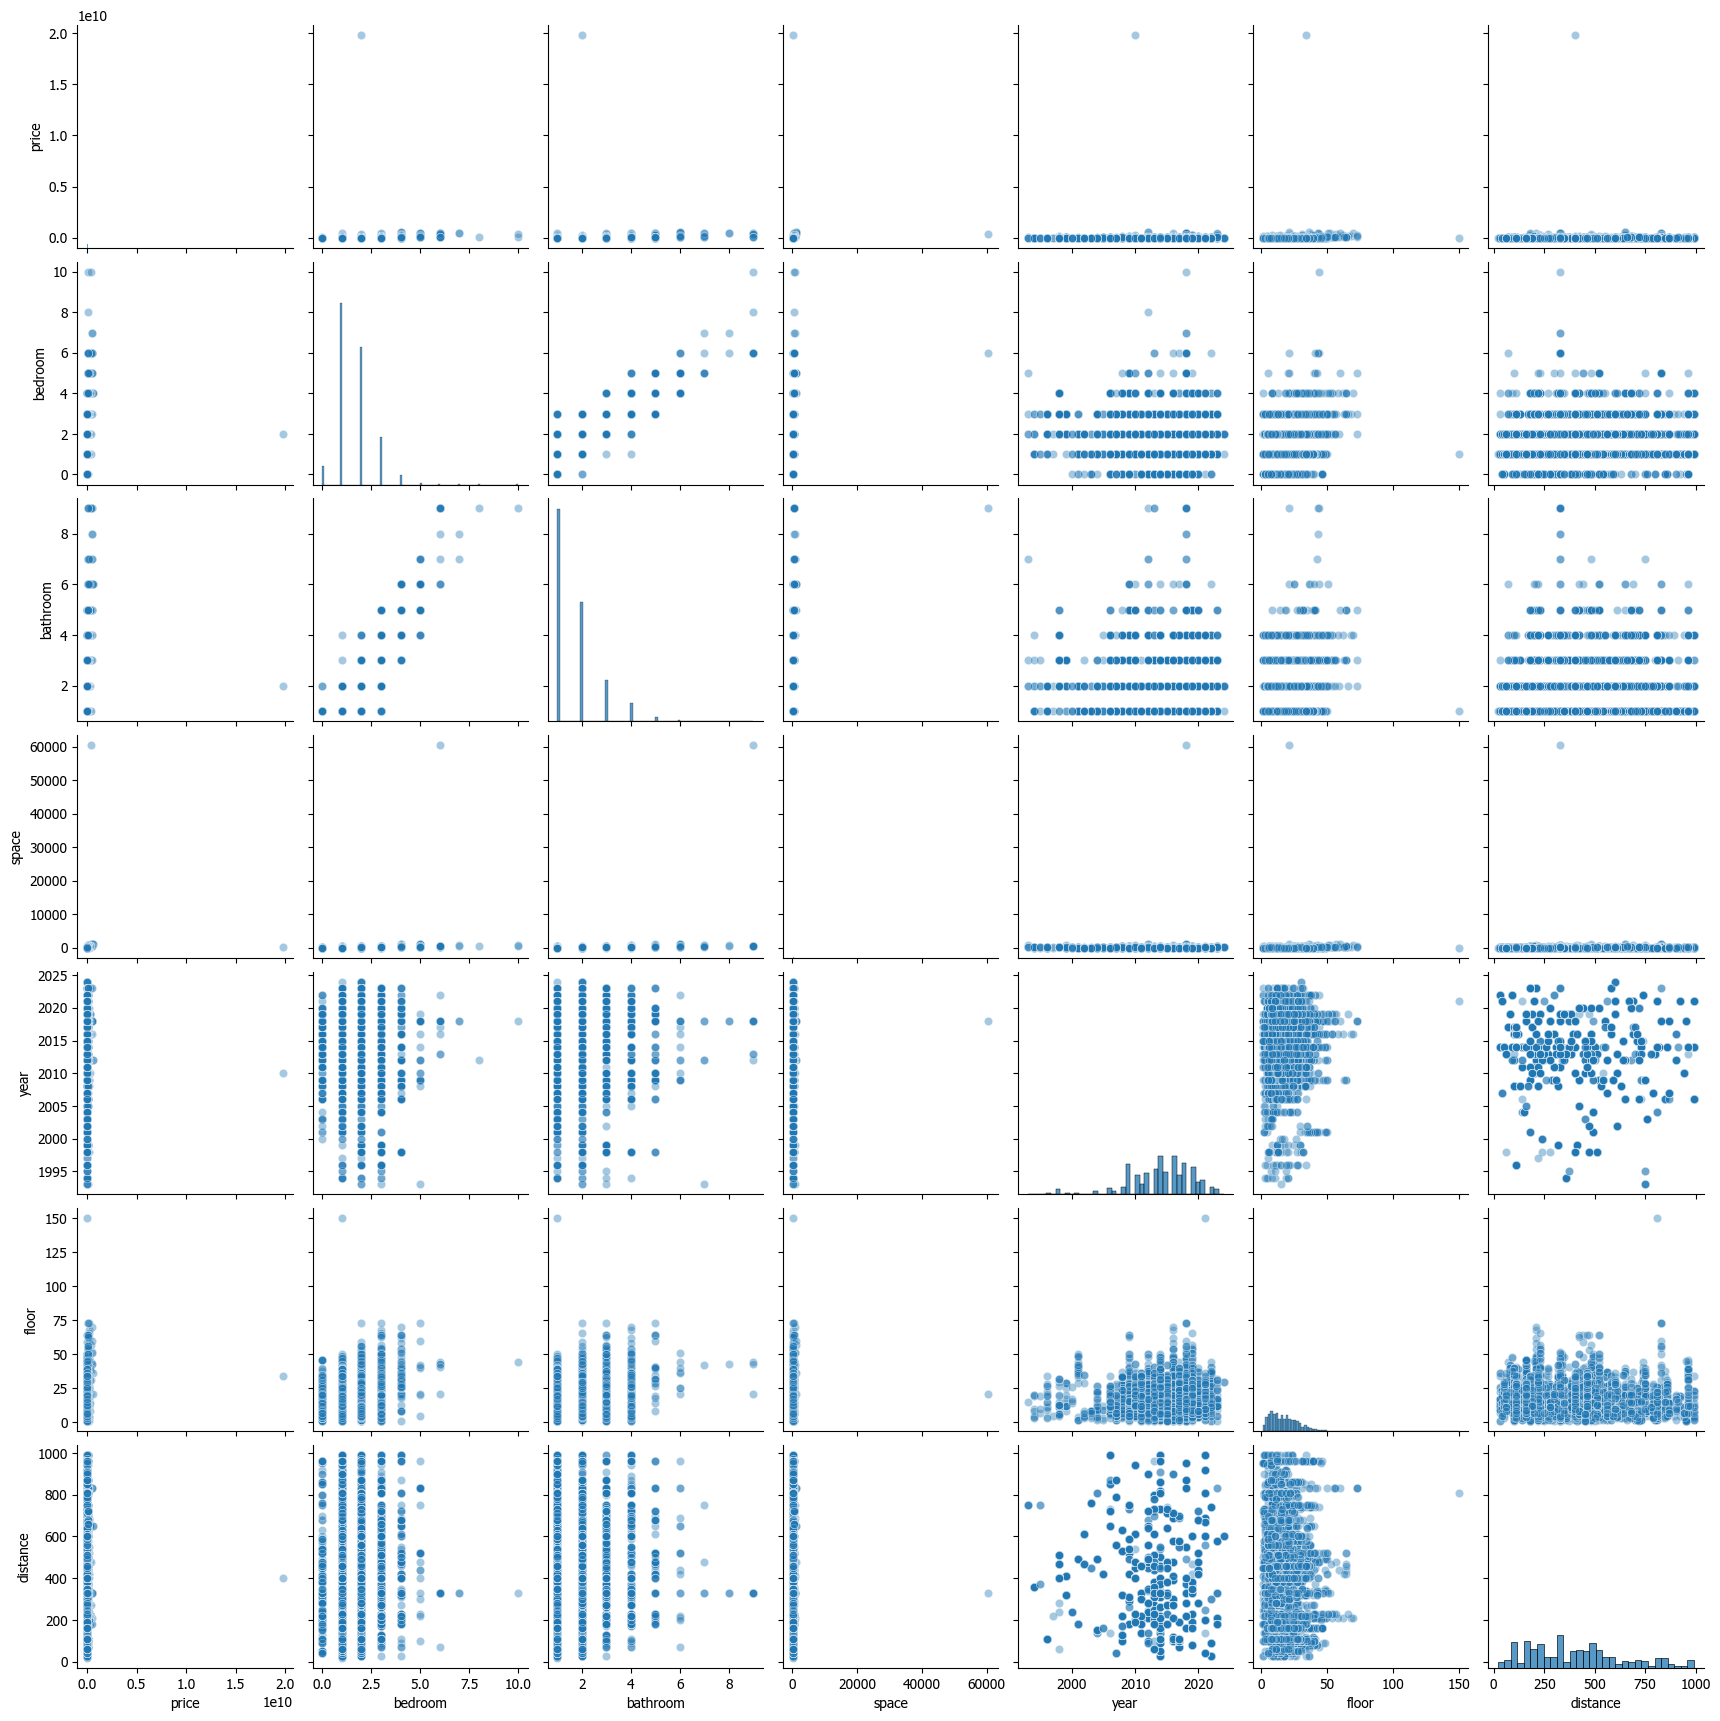

<Figure size 640x480 with 0 Axes>

In [62]:
sns.pairplot(plot_column, vars=['price','bedroom','bathroom', 'space', 'year', 'floor', 'distance'], 
             plot_kws={'alpha': .4})
plt.show()
plt.clf()

# LabelEncoder ( เป็น order )

`ตกแต่งครบ    2
มีบางส่วน     1
ไม่มี         0`

In [63]:
df['furniture'].unique()

array([nan, 'ตกแต่งครบ', 'มีบางส่วน', 'ไม่มี'], dtype=object)

In [64]:
furniture = {'ตกแต่งครบ' : 2, 'มีบางส่วน' : 1, 'ไม่มี' : 0}

df['furniture_encoded'] = df['furniture'].map(furniture)
df = df.drop('furniture', axis =1 )
df.head(5)


,name,price,district,bedroom,bathroom,space,year,type,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room,furniture_encoded
0,Supalai Casa Riva,17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
1,Supalai Casa Riva,19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
2,Lumpini Place Rama 3 - Riverview,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
3,Lumpini Place Rama 3 - Riverview,3100000.0,บางโคล่,1.0,1.0,40.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
4,Lumpini Place Rama 3 - Riverview,28500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN


# Change categorical column to one-hot encoding

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7444 entries, 0 to 7476
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 7435 non-null   object 
 1   price                7436 non-null   float64
 2   district             7444 non-null   object 
 3   bedroom              7391 non-null   float64
 4   bathroom             7369 non-null   float64
 5   space                7441 non-null   float64
 6   year                 6641 non-null   float64
 7   type                 6642 non-null   object 
 8   floor                4195 non-null   float64
 9   distance             6583 non-null   float64
 10  station_id           6583 non-null   object 
 11  is_Security          7444 non-null   bool   
 12  is_Laundry           7444 non-null   bool   
 13  is_Parking_Lot       7444 non-null   bool   
 14  is_Bus_Stop          7444 non-null   bool   
 15  is_Cleaning          7444 non-null   b

In [66]:
df1 = df.copy()

In [67]:
category_column = ['type','station_id']

In [68]:
df_dummy = pd.get_dummies(df['district'], prefix='แขวง',prefix_sep='' ,drop_first=True)
df = pd.merge(df, df_dummy, left_index=True, right_index=True , how = "inner")
df = df.drop('district', axis = 1)

In [69]:
for col in category_column:
    df_dummy = pd.get_dummies(df[col], drop_first=True)
    df = pd.merge(df, df_dummy, left_index=True, right_index=True , how = "inner")
    df = df.drop(col, axis = 1)

In [70]:
df.head()

,name,price,bedroom,bathroom,space,year,floor,distance,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room,furniture_encoded,แขวงคลองสาน,แขวงช่องนนทรี,แขวงดาวคะนอง,แขวงตลาดพลู,แขวงทุ่งมหาเมฆ,แขวงทุ่งวัดดอน,แขวงบางคอแหลม,แขวงบางยี่เรือ,แขวงบางรัก,แขวงบางลำภูล่าง,แขวงบางโคล่,แขวงบางโพงพาง,แขวงบุคคโล,แขวงปทุมวัน,แขวงมหาพฤฒาราม,แขวงยานนาวา,แขวงรองเมือง,แขวงลุมพินี,แขวงวังใหม่,แขวงวัดพระยาไกร,แขวงสมเด็จเจ้าพระยา,แขวงสำเหร่,แขวงสีลม,แขวงสี่พระยา,แขวงสุริยวงศ์,แขวงหิรัญรูจี,เช่าซื้อระยะยาว 30 ปี,เช่าระยะยาว,B10,B11,B12,B2,B3,B4,B5,B6,B7,B8,B9,BL24,BL25,BL26,BL27,BL28,BL30,E1,E14,E2,E3,G2,G3,RN07,S1,S10,S11,S2,S3,S4,S5,S6,S7,S8,S9,W1
0,Supalai Casa Riva,17500000.0,3.0,3.0,240.0,2006.0,NaN,720.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Supalai Casa Riva,19000000.0,3.0,3.0,230.0,2006.0,NaN,720.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Lumpini Place Rama 3 - Riverview,2500000.0,1.0,1.0,39.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Lumpini Place Rama 3 - Riverview,3100000.0,1.0,1.0,40.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Lumpini Place Rama 3 - Riverview,28500000.0,1.0,1.0,39.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
df.shape

(7444, 87)

<a id="3"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 3. Models </p>

**Model** คือ สิ่งที่ใช้สร้างความสัมพันธ์ระหว่างข้อมูลเข้า (Input data) และผลลัพธ์ที่ต้องการ (Output)  โดยใช้อัลกอริทึมเพื่อเรียนรู้และนำไปใช้ประโยชน์ต่อในอนาคต ซึ่งการสร้าง Model ใน Machine Learning จะเริ่มต้นด้วยการคัดเลือก Algorithm ที่สำคัญและเหมาะสมกับปัญหาที่ต้องการแก้ไข หลังจากนั้นจะนำข้อมูลมาแบ่งเป็น 2 ส่วนคือ  Training set และ Test set 

    - Training set : การนำข้อมูลจริงที่มีอยู่แล้วมาใส่เป็นตัวอย่างเพื่อให้เครื่องเรียนรู้ ซึ่งในการ train อาจะมีการปรับเปลี่ยน parameter ของ Algorithm เพื่อให้ model ที่ได้มีประสิทธิภาพและความแม่นยำสูงสุด โดยใช้วิธีการประมาณค่าความคลาดเคลื่อนระหว่างค่าที่คำนวณได้จาก Model กับค่าจริง (Error) และนำไปปรับปรุง Model ให้มีค่า Error น้อยลง
    - Test set : เมื่อ Model ได้รับการ Train เสร็จแล้ว จึงจะนำ Model มาทดสอบด้วยข้อมูลที่ไม่เคยเห็นมาก่อน (Test Data / Unseen Data) เพื่อวัดความแม่นยำของ Model ว่าสามารถทำนายผลลัพธ์ได้ถูกต้องเท่าใด

หลังจากได้ Model ที่มีประสิทธิภาพและมีความแม่นยำสูงสุดแล้ว จะนำข้อมูลที่ได้จากการทำ Model ไปใช้ในการทำนาย (Prediction) หรือการจัดกลุ่ม (Clustering) ของข้อมูลใหม่ที่มาถึง 



In [72]:
df['price'].dropna(inplace=True)

In [73]:
df.dropna(subset=['price'], inplace=True)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7436 entries, 0 to 7476
Data columns (total 87 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   7427 non-null   object 
 1   price                  7436 non-null   float64
 2   bedroom                7386 non-null   float64
 3   bathroom               7364 non-null   float64
 4   space                  7435 non-null   float64
 5   year                   6634 non-null   float64
 6   floor                  4190 non-null   float64
 7   distance               6576 non-null   float64
 8   is_Security            7436 non-null   bool   
 9   is_Laundry             7436 non-null   bool   
 10  is_Parking_Lot         7436 non-null   bool   
 11  is_Bus_Stop            7436 non-null   bool   
 12  is_Cleaning            7436 non-null   bool   
 13  is_Fitness             7436 non-null   bool   
 14  is_Convenient_Store    7436 non-null   bool   
 15  is_B

- ดูมิติของข้อมูล 

In [75]:
df.shape

(7436, 87)

<a id="3.1"></a>
##  3.1 Spilt train test

In [76]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['price', 'name'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
from sklearn.metrics import mean_squared_error
from flaml import AutoML
from math import sqrt

<a id="3.2"></a>
## 3.2 FLAML

**FLAML**  เป็นชื่อของ Software Open Source สำหรับการทำ Model Machine Learning และเป็นเครื่องมือที่ช่วยให้นักพัฒนาสามารถปรับแต่ง Parameter ต่างๆ ของโมเดลได้อย่าง *รวดเร็ว* และ *มีประสิทธิภาพสูง* โดยไม่ต้องใช้ทรัพยากรมาก ผู้ใช้สามารถเลือก Model Selection , Hyperparameter ที่ต้องการ มาใช้เปรียบเทียบกันได้อย่างอิสระ 

FLAML มีความน่าสนใจเป็นอย่างมาก เนื่องจากตัวหลักการของ FLAML คือการใช้โปรแกรมประมวลผลแบบโดยสาร (Meta-Learning) เพื่อเรียนรู้และเลือกใช้เทคนิคการเรียนรู้ที่เหมาะสมสำหรับข้อมูลที่กำลังจะนำมาสร้างโมเดล โดย FLAML จะปรับแต่งพารามิเตอร์ของโมเดลอัตโนมัติด้วยการใช้การค้นหาแบบกระจาย (Distributed Search) ซึ่งจะช่วยลดเวลาในการค้นหาพารามิเตอร์ที่เหมาะสมและเพิ่มประสิทธิภาพในการเทรนโมเดลได้มากทีเดียว

นอกจากนี้ FLAML ยังมีฟีเจอร์สำหรับการสร้างอัลกอริทึมเพื่อเลือกคุณลักษณะ (Feature Selection) และการจัดการข้อมูลที่ไม่สมดุล (Imbalanced Data) ได้อีกด้วย จึงเป็น Library ที่เหมาะสมที่เราจะนำมาปรับใช้กับ Dataset นี้ 



สำหรับ Dataset นี้ เราได้เลือก Model ที่นำมาเปรียบเทียบทั้งหมด 4 Model ได้แก่ 

1. Light GBM (Light Gradient Boosting)

    - ข้อดี 
        1. มีความรวดเร็วในการ train model เนื่องจากเป็นการใช้ parallel computing   
        2. มีประสิทธิภาพการทำนายได้มากกว่า Model อื่นเมื่อต้องเจอกับข้อมูลที่มีขนาดใหญ่ และจำนวนมาก
        3. ไม่ต้องทำ Feature Scaling ก่อนเพราะสามารถรองรับ Imbalanced data ได้ 
    - ข้อเสีย
        1. ไม่เหมาะสมกับการจัดการข้อมูลที่มีขนาดเล็ก เนื่องจากอาจทำให้เกิดปัญหา overfitting ได้  

2. XGBoost (Extreme Gradient Boosting)

    - ข้อดี 
        1. มีความรวดเร็วในการ train model เนื่องจากเป็นการใช้ parallel computing
        2. สามารถ Train Model ได้กับข้อมูลที่มีจำนวน Feature มาก และ Sample น้อย โดยไม่เกิด overfitting 
        3. สามารถจัดการกับ Missing Values ได้ดี
    - ข้อเสีย
        1. ต้องกำหนดจำนวน Hyperparameters มาก และถ้ากำหนดไม่เหมาะสม อาจทำให้โมเดลไม่มีประสิทธิภาพได้ 
        2. อาจใช้เวลานานในการ Train Model ในข้อมูลที่มีจำนวน Feature มาก และมีขนาดใหญ่

3. Catboost (Gradient Boosting with Categorical feature support)

    - ข้อดี 
        1. มีความรวดเร็วในการ train model เนื่องจาก เป็นการใช้ parallel computing
        2. สามารถ Train Model ได้กับข้อมูลที่มีจำนวน Sample น้อย
        3. สามารถจัดการกับข้อมูลที่มีความซับซ้อนสูง และมีจำนวน Feature มากได้ดี
    - ข้อเสีย
        1. อาจใช้เวลา Train Model นานกว่า Algorithm อื่น ๆ เช่น XGBoost หรือ LightGBM
        2. ไม่สามารถรองรับ Imbalanced Data ได้จึงจำเป็นต้องทำ Feature Selection ก่อนที่จะ Train Model
        3. ต้องกำหนดจำนวน Hyperparameters มาก และถ้ากำหนดไม่เหมาะสม อาจทำให้โมเดลไม่มีประสิทธิภาพได้
        
4. XGB limitdepth (XGBoost ที่มีการกำหนดความลึกของต้นไม้)


In [78]:
# Instantiate AutoML object
automl = AutoML()

# Define the search space for hyperparameters for regression
automl_settings = {
    "time_budget": 120,  # maximum time in seconds for training
    "metric": 'r2',
    "task": "regression",  # specify the task type as regression
    "log_file_name": "automl.log",  # log file to record the training progress
    "n_splits": 5,  # number of cross-validation folds
    "eval_method": "auto",  # specify evaluation metric as auto for regression
    "split_type": "uniform",  # type of train-test split for cross-validation
    "model_history": True,  # record model training history
    "n_jobs": 2,  # number of parallel jobs to run during training
    "estimator_list": ['lgbm', 'xgboost', 'catboost', 'xgb_limitdepth']
}

# Search for the best model and hyperparameters for regression
automl.fit(
    X_train=X_train,
    y_train=y_train,
    **automl_settings
)

#Predict
print(automl.predict(X_train))

# Access the best model and hyperparameters
best_model = automl.model.estimator
# best_log = automl.best_log


# Check if best_model is not None before accessing the best hyperparameters
if best_model is not None:
    # Print the best model and hyperparameters
    print(f"Best model: {best_model}")
    # print(f"Best hyperparameters: {best_log}")
else:
    print("No best model found.")


[flaml.automl.logger: 04-17 21:07:26] {1768} INFO - task = regression
[flaml.automl.logger: 04-17 21:07:26] {1775} INFO - Data split method: uniform
[flaml.automl.logger: 04-17 21:07:26] {1778} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-17 21:07:27] {1891} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 04-17 21:07:27] {2011} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost', 'xgb_limitdepth']
[flaml.automl.logger: 04-17 21:07:27] {2341} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-17 21:07:27] {2479} INFO - Estimated sufficient time budget=269s. Estimated necessary time budget=2s.
[flaml.automl.logger: 04-17 21:07:27] {2526} INFO -  at 0.3s,	estimator lgbm's best error=0.6259,	best estimator lgbm's best error=0.6259
[flaml.automl.logger: 04-17 21:07:27] {2341} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-17 21:07:27] {2526} INFO -  at 0.3s,	estimator lgbm's best error=0.6259,	best estimator lgb

### Best Model
หลังจากใช้ FLAML ในการประมวลผลเพื่อให้ได้ model ที่ดีที่สุดแล้ว เราสามารถสร้างฟังก์ชั่นสำหรับการแสดงผลว่า เมื่อนำโมเดลไปใช้กับข้อมูลนั้น มีความแม่นยำ (score) เท่าไหร่การทำนายข้อมูล รวมทั้งแสดง ค่าคลาดเคลื่อน (error) ของการทำนาย ซึ่งในที่นี้เราจะใช้ Mean squared error และ root mean squared error เป็นตัววัด 

การหา Error ใน Machine Learning Model จะช่วยให้ผู้ใช้งานสามารถปรับปรุงโมเดลได้อย่างเหมาะสม เช่น การปรับแต่ง Hyperparameters หรือเลือกโมเดลที่เหมาะสมกับปัญหา โดยการลด Error จะหมายถึงการปรับโมเดลให้มีความแม่นยำมากขึ้นและเข้าใกล้ค่าผลลัพธ์จริงมากขึ้น

In [79]:
def display_model_score(model):

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print("-"*50)
    print(model.__class__.__name__)
    print("-"*50)
    print(f"Coefficient of Determination")
    print(f"train score : {model.score(X_train, y_train)}")
    print(f"test  score : {model.score(X_test, y_test)}")
    print("-"*50)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", sqrt(mse))
    print("-"*50)

### Feature Importance 

การหา Feature Importance เป็นการวิเคราะห์ว่าแต่ละ Feature ในข้อมูลมีผลกระทบต่อผลลัพธ์ของโมเดล Machine Learning อย่างไร ซึ่งจะช่วยให้ผู้ใช้งานสามารถเข้าใจได้ว่า Feature ใดบ้างที่สำคัญและมีผลต่อผลลัพธ์ของโมเดลมากที่สุด ผู้ใช้งานสามารถนำ Feature นั้นมาใช้ในการ Train Model อย่างเฉพาะเจาะจง หรือลบ Feature ที่ไม่สำคัญออกจากข้อมูลได้ ซึ่งจะช่วยให้ผู้ใช้งานสามารถดำเนินการปรับปรุงและพัฒนาโมเดลได้อย่างมีประสิทธิภาพมากขึ้น


In [80]:
def display_important_feature(models):
    importances = models.feature_importances_
    indices = np.argsort(importances)
    features = X.columns
    plt.figure(figsize=(15, 15))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

--------------------------------------------------
LGBMRegressor
--------------------------------------------------
Coefficient of Determination
train score : 0.996379967592305
test  score : 0.9202107486075773
--------------------------------------------------
Mean Squared Error: 121914835554008.16
Root Mean Squared Error: 11041505.130823793
--------------------------------------------------


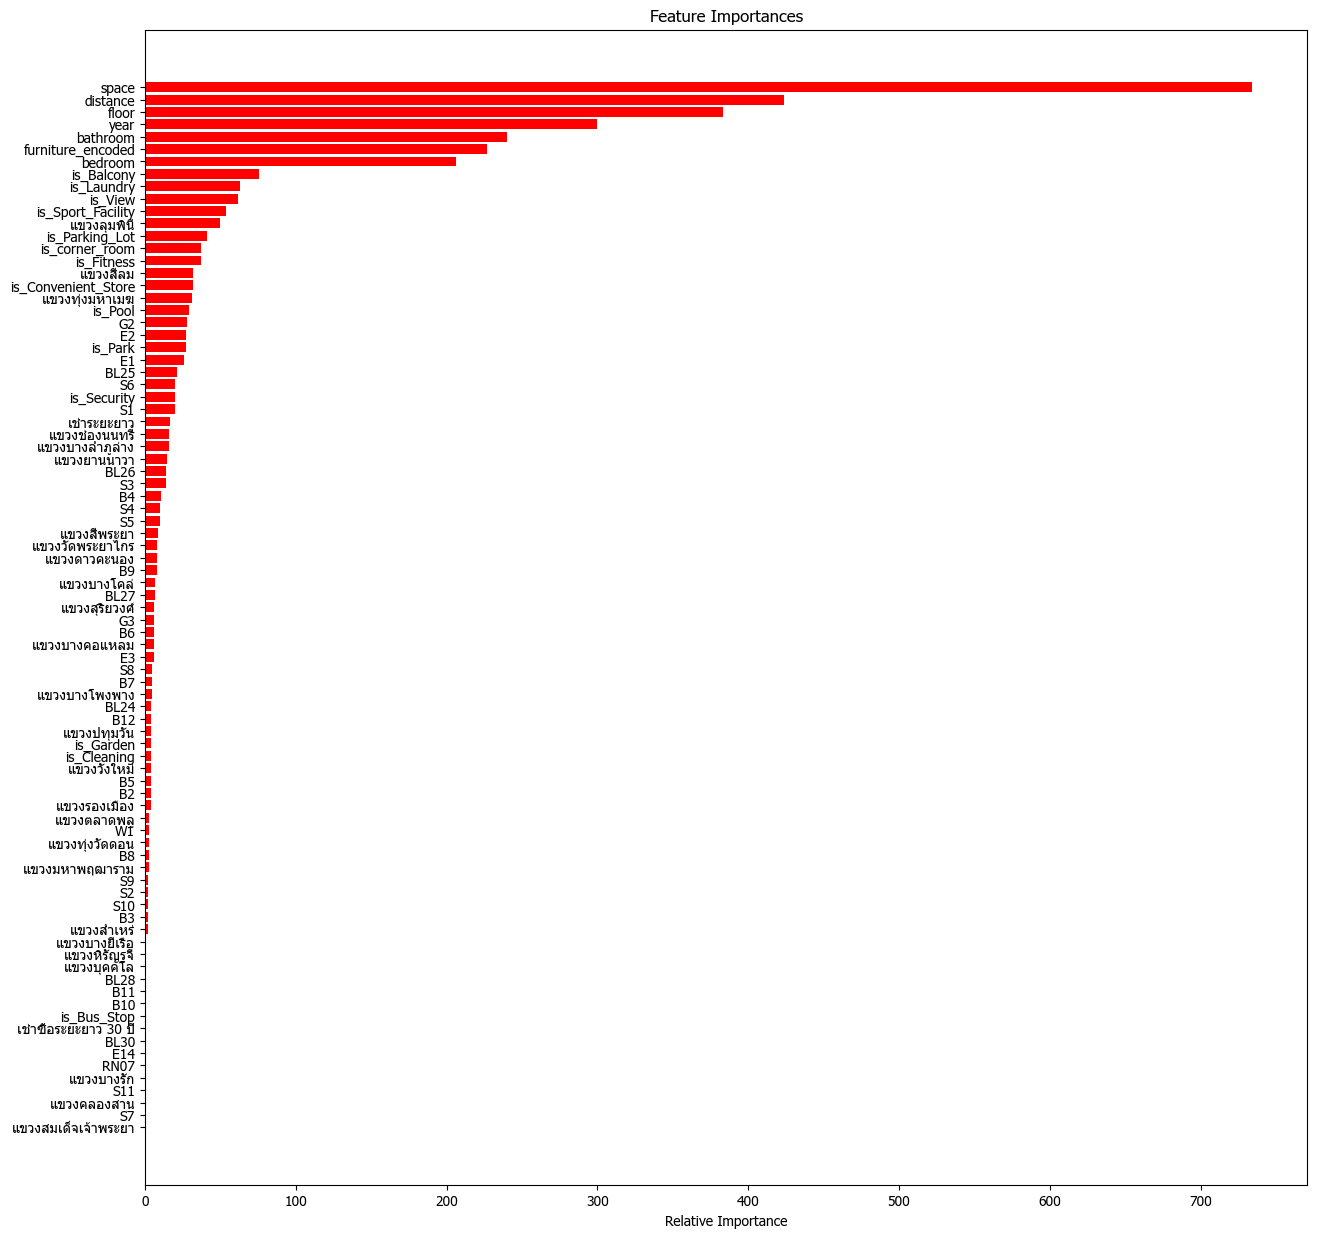

In [81]:
best_model.fit(X_train, y_train)
display_model_score(best_model)
display_important_feature(best_model)